### The goal of this study is to reproduce the results of the paper “Semi-supervised Semantic Segmentation via Strong-weak Dual-branch Network".

### This file contains class definitions for loading VOC Strong, Weak and DualBranch datasets.

#1.Preperation

##1.1. Getting the Dataset
For this project, we need two datasets: PASCAL VOC 2012 and Semantic Boundary Detection dataset. We assume that these datasets are already put on Google drive.The steps for preparing the datasets are explained in the readme file.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2 MB 50 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.2 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
plotnine 0.6.0 requires scipy>=1.2.0, but you have scipy 1.1.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


SBD dataset and VOCDevkit are taken from google drive and extracted.

In [ ]:
#!ls /content/drive/MyDrive/DSRG_1500_iterations/Results/pred/ | wc -l
#SBD strong data with train_noval.txt file
!tar -xzf /content/drive/MyDrive/SBD_Strong.tgz
# get train_noval.txt that contains the names of image files in the dataset
#!wget http://home.bharathh.info/pubs/codes/SBD/train_noval.txt  
#!mv train_noval.txt benchmark_RELEASE
#!tar -cvzf /content/drive/MyDrive/SBD_Strong.tgz benchmark_RELEASE 
#!rm -rf VOCdevkit
!tar -xf /content/drive/MyDrive/VOC_Strong.tar

Necessary imported libraries

In [ ]:
import numpy as np
from PIL import Image
import random

import os
from os.path import join as pjoin
import collections
import json
import imageio
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm

import torch
from torchvision import transforms as T
from torchvision.transforms import functional as F
from torch.utils import data
from torchvision import transforms

Defining custom transform methods.

In [ ]:
################## custom transform  ##################
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class RandomHorizontalFlip(object):
    def __init__(self, flip_prob):
        self.flip_prob = flip_prob

    def __call__(self, image, target):
        if random.random() < self.flip_prob:
            image = F.hflip(image)
            target = F.hflip(target)
        return image, target

class Resize(object):
    def __call__(self, image, target):
        image = F.resize(image,[256,256]),
        target = F.resize(target,[256,256])
        return np.asarray(image), np.asarray(target)

class ToTensor(object):
    def __call__(self, image, target):
        # print(type(image))
        # image = torch.from_numpy(image)
        # target = torch.from_numpy(image)
        image = F.to_tensor(image)
        target = torch.as_tensor(np.array(target), dtype=torch.int64)
        return image, target


class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image, target):
        image = F.normalize(image, mean=self.mean, std=self.std)
        return image, target

Some utility functions

In [ ]:
def get_pascal_labels():
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

In [ ]:
def encode_segmap(mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)

        return label_mask


def decode_segmap(label_mask, plot=False):
        """
        Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """

        label_colours = get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, 21): #for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

#2.Single Branch Network Datasets

##2.1.PASCAL VOC Strong Dataset

In [ ]:
class VOCStrongDataset(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        split="trainval",
        is_transform=False,
        img_size=512,
        augmentations=None,
        img_norm=True,
        generate_pre_encoded=False,
        target_label=True
    ):
        self.root = root
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.generate_pre_encoded = generate_pre_encoded
        self.target_label = target_label
        
        for split in ["train", "val", "trainval"]:
          path = pjoin(self.root, "ImageSets/Segmentation", split + ".txt")
          file_list = tuple(open(path, "r"))
          file_list = [id_.rstrip() for id_ in file_list]
          self.files[split] = file_list
       
        
        if (generate_pre_encoded):
          self.generate_label_masks()
        
        ######################## train transform ########################
        self.tf = Compose(                                                   
            [                                                                
                # add more transformations as you see fit
                RandomHorizontalFlip(0.3),                                    
                ToTensor(),                                                  
                Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]                                                                
        )                                                                    

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        if (self.target_label):
          lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png") # returns mask-label for train mode
        else:
          lbl_path = pjoin(self.root, "SegmentationClass", im_name + ".png")  # returns ground truth, for eval mode
        im = Image.open(im_path)
        lbl = Image.open(lbl_path)

        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        
        im, lbl = self.transform(im, lbl) 
         
        if (self.target_label):
          lbl = torch.from_numpy(np.array(lbl)).long()
          lbl[lbl == 255] = 0
          return im, torch.clamp(lbl, max=20)
        else:
          return im, lbl

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
 
        if self.is_transform == True:
            img,lbl = self.tf(img,lbl)
        else:
            tf2 = Compose(                                                   
            [                                                                                                    
                ToTensor(),                                                  
                Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])            
            img, lbl = tf2(img, lbl)

        return img, lbl


    def generate_label_masks(self):
        """ pre-encode all segmentation labels into the
        common label_mask format. This
        function also defines the `train_aug` and `train_aug_val` data splits
        according to the description in the class docstring
        """
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["trainval"]

        # keep unique elements (stable)
        train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
        self.files["train_aug"] = train_aug
        set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png")) 
        expected = np.unique(self.files["train_aug"] + self.files["val"]).size

        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation label masks...")

            for ii in tqdm(self.files["trainval"]):
                fname = ii + ".png"  
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = encode_segmap(m.imread(lbl_path))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, fname), lbl)

        assert expected == 2913, "unexpected dataset sizes"

In [ ]:
# dataset variable
#dst = VOCStrongDataset(root='VOCdevkit/VOC2012/', is_transform=True,split="trainval",img_size=328, generate_pre_encoded=True)
#dst = VOCStrongDataset(root='VOCdevkit/VOC2012/', is_transform=True,split="trainval",img_size=328, generate_pre_encoded=True)

In [ ]:
#!rm -rf VOCdevkit/VOC2012/SegmentationClass/pre_encoded/

#!tar -cvf /content/drive/MyDrive/VOCStrong-pre_encoded.tar VOCdevkit/VOC2012/SegmentationClass/pre_encoded/

##2.2.PASCAL VOC Weak Dataset

In [ ]:
class VOCWeakDataset(data.Dataset):
    """Data loader for weakly annotated  VOC dataset. Weak annotations are 
    generated from DSRG for the val set of the VOC dataset.
    root: Directory of the original dataset
    weak_path: Directory of the weakly annotated masks
    """

    def __init__(
        self,
        root,  
        weak_path=None,
        split="val",
        is_transform=False,
        img_size=328,
        augmentations=None,
        img_norm=True,
        generate_pre_encoded=False
    ):
        self.root = root
        self.weak_path = weak_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.generate_pre_encoded = generate_pre_encoded

        path = pjoin(self.root, "ImageSets/Segmentation", split + ".txt")
        file_list = tuple(open(path, "r"))
        file_list = [id_.rstrip() for id_ in file_list]
        self.files[split] = file_list

        if (generate_pre_encoded):
          self.generate_label_masks()

        ########################### train transform #########################
        self.tf = Compose(                                                   
            [                                                                  
                RandomHorizontalFlip(0.3),                                    
                ToTensor(),                                                  
                Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]                                                                
        )                                                                    

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/weak_pre_encoded", im_name + ".png") 
        im = Image.open(im_path)
        lbl = Image.open(lbl_path)
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform == True:
            im, lbl = self.transform(im, lbl) 
         
        return im, torch.clamp(lbl, max=20)

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
 
        img,lbl = self.tf(img,lbl)
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def generate_label_masks(self):
        """
        Generates pre eoncoded label masks for weak data
        """
        weak_path = self.weak_path
        target_path = pjoin(self.root, "SegmentationClass/weak_pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["val"]

        pre_encoded = glob.glob(pjoin(target_path, "*.png")) 
        expected = len(self.files["val"])
        
        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")

            for ii in tqdm(self.files["val"]):
                fname = ii + ".png" 
                input_fname = ii + "_pred.png" 
                lbl_path = pjoin(self.weak_path, "Results/pred", input_fname)
                lbl = encode_segmap(m.imread(lbl_path))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, fname), lbl)

        assert expected == 1449, "unexpected dataset sizes"

In [ ]:
# dataset variable
# dst = VOCWeakDataset(root='VOCdevkit/VOC2012/', weak_path='/content/drive/MyDrive/VOCWeak/', is_transform=True, split="val", img_size=328, generate_pre_encoded=True)


In [ ]:
#!rm -rf VOCdevkit/VOC2012/SegmentationClass/weak_pre_encoded/

#storing results to drive
#!tar -cvf /content/drive/MyDrive/VOCWeak-pre_encoded.tar VOCdevkit/VOC2012/SegmentationClass/weak_pre_encoded/

##2.3.SBD Weak Dataset

In [ ]:
class SBDWeakDataset(data.Dataset):
    """Data loader for weakly annotated  SBD dataset. Weak annotations are 
    generated from DSRG for the train_noval set of the SBD dataset.
    root: Directory of the original dataset
    weak_path: Directory of the weakly annotated masks
    """

    def __init__(
        self,
        root,  
        weak_path=None,
        split="train_noval",
        is_transform=False,
        img_size=328,
        augmentations=None,
        img_norm=True,
        generate_pre_encoded=False
    ):
        self.root = root
        self.weak_path = weak_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.generate_pre_encoded = generate_pre_encoded

        path = pjoin(self.root, split + ".txt")
        file_list = tuple(open(path, "r"))
        file_list = [id_.rstrip() for id_ in file_list]
        self.files[split] = file_list
        
        if (generate_pre_encoded):
          self.generate_label_masks()
        
        ######################### train transform ##########################
        self.tf = Compose(                                                   
            [                                                                
                # add more trasnformations as you see fit
                RandomHorizontalFlip(0.3),                                    
                ToTensor(),                                                  
                Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]                                                                
        )                                                                    

    def __len__(self):
        #return len(self.files[self.split])
        return 1500 # only first 1500 elements are used

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "dataset/img", im_name + ".jpg")
        lbl_path = pjoin(self.root, "weak_pre_encoded", im_name + ".png") 
        im = Image.open(im_path)
        lbl = Image.open(lbl_path)
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform == True:
            im, lbl = self.transform(im, lbl) 
        
        return im, torch.clamp(lbl, max=20)

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
 
        img,lbl = self.tf(img,lbl)
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def generate_label_masks(self):
        """
        Generates pre eoncoded label masks for weak data
        """
        weak_path = self.weak_path
        target_path = pjoin(self.root, "weak_pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["train_noval"]

        pre_encoded = glob.glob(pjoin(target_path, "*.png")) 
        expected = len(self.files["train_noval"])
        
        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")

            for ii in tqdm(self.files["train_noval"]):
                fname = ii + ".png" 
                input_fname = ii + "_pred.png" 
                lbl_path = pjoin(self.weak_path, "1/pred", input_fname)
                lbl = encode_segmap(m.imread(lbl_path))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, fname), lbl)

        assert expected == 5623, "unexpected dataset sizes"

In [ ]:
# dataset variable
#dst = SBDWeakDataset(root='benchmark_RELEASE/', weak_path='/content/drive/MyDrive/SBDWeak/', is_transform=True, img_size=328, generate_pre_encoded=True)

In [ ]:
#!rm -rf benchmark_RELEASE/weak_pre_encoded/

#storing results to drive
#!tar -cvf /content/drive/MyDrive/SBDWeak-pre_encoded.tar benchmark_RELEASE/weak_pre_encoded/

#3.Dual Branch Network Dataset

##3.1.Dataset Definition to Feed Data To Dual Branch Network

In [ ]:
class DualNetworkDataset(data.Dataset):
    def __init__(
        self,
        root_strong,  # Strong annotations dataset root path, pre-encoded images are also stored in this directory
        root_weak,    # Weak annotations dataset root path, input images are taken from here
        split_strong="trainval",
        split_weak="train_noval",
        is_transform=False,
        img_size=512,
        augmentations=None,
        img_norm=True,
        target_label=True
    ):
        self.root_strong = root_strong
        self.root_weak = root_weak
        self.split_strong = split_strong
        self.split_weak = split_weak
        self.is_transform = is_transform
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.target_label = target_label

        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files_strong = collections.defaultdict(list)
        self.files_weak = collections.defaultdict(list)

        for split_strong in ["train", "val", "trainval"]:
          # strong data part
          path_strong = pjoin(self.root_strong, "ImageSets/Segmentation", split_strong + ".txt")
          file_list_strong = tuple(open(path_strong, "r"))
          file_list_strong = [id_.rstrip() for id_ in file_list_strong]
          self.files_strong[split_strong] = file_list_strong
          # weak data part
          path_weak = pjoin(self.root_weak, split_weak + ".txt")
          file_list_weak = tuple(open(path_weak, "r"))
          file_list_weak = [id_.rstrip() for id_ in file_list_weak]
          self.files_weak[split_weak] = file_list_weak
        
        ######################## train transform ########################
        self.tf = Compose(                                                   
            [                                                                
                # add more transformations as you see fit
                RandomHorizontalFlip(0.3),                                    
                ToTensor(),                                                  
                Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]                                                                
        )                                                                    

    def __len__(self):
        return len(self.files_strong[self.split_strong])

    def __getitem__(self, index):
        im_strong_name = self.files_strong[self.split_strong][index]
        im_strong_path = pjoin(self.root_strong, "JPEGImages", im_strong_name + ".jpg")
        lbl_strong_path = pjoin(self.root_strong, "SegmentationClass/pre_encoded", im_strong_name + ".png") # returns mask-label for train mode
        
        im_weak_name = self.files_weak[self.split_weak][index]
        im_weak_path = pjoin(self.root_weak, "dataset/img", im_weak_name + ".jpg")
        lbl_weak_path = pjoin(self.root_weak, "weak_pre_encoded", im_weak_name + ".png") 
        
        im_strong = Image.open(im_strong_path)
        lbl_strong = Image.open(lbl_strong_path)
        im_weak = Image.open(im_weak_path)
        lbl_weak = Image.open(lbl_weak_path)

        if self.augmentations is not None:
            im_strong, lbl_strong = self.augmentations(im_strong, lbl_strong)
            im_weak, lbl_weak = self.augmentations(im_weak, lbl_weak)

        im_strong, lbl_strong = self.transform(im_strong, lbl_strong)
        im_weak, lbl_weak = self.transform(im_weak, lbl_weak) 
        lbl_strong = torch.from_numpy(np.array(lbl_strong)).long()
        lbl_strong[lbl_strong == 255] = 0
        lbl_strong = torch.clamp(lbl_strong, max=20)
        lbl_weak = torch.from_numpy(np.array(lbl_weak)).long()
        lbl_weak[lbl_strong == 255] = 0
        lbl_weak = torch.clamp(lbl_weak, max=20)
        
        combined_im = torch.cat((im_strong, im_weak), 2)
        combined_lbl = torch.cat((lbl_strong, lbl_weak), 1)
        
        return combined_im, combined_lbl

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
 
        if self.is_transform == True:
            img,lbl = self.tf(img,lbl)
        else:
            tf2 = Compose(                                                   
            [                                                                                                    
                ToTensor(),                                                  
                Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])            
            img, lbl = tf2(img, lbl)

        return img, lbl

##3.1. Show Data 

In [ ]:
# Extracting necessary files
!tar -xvf /content/drive/MyDrive/VOCStrong-pre_encoded.tar VOCdevkit/VOC2012/SegmentationClass/pre_encoded/
!tar -xvf /content/drive/MyDrive/SBDWeak-pre_encoded.tar benchmark_RELEASE/weak_pre_encoded/

Görüntülenen çıkış son 5000 satıra kısaltıldı.
benchmark_RELEASE/weak_pre_encoded/2008_000260.png
benchmark_RELEASE/weak_pre_encoded/2010_005949.png
benchmark_RELEASE/weak_pre_encoded/2009_002626.png
benchmark_RELEASE/weak_pre_encoded/2010_002193.png
benchmark_RELEASE/weak_pre_encoded/2010_001850.png
benchmark_RELEASE/weak_pre_encoded/2008_000941.png
benchmark_RELEASE/weak_pre_encoded/2010_003329.png
benchmark_RELEASE/weak_pre_encoded/2008_001880.png
benchmark_RELEASE/weak_pre_encoded/2008_006400.png
benchmark_RELEASE/weak_pre_encoded/2008_006606.png
benchmark_RELEASE/weak_pre_encoded/2010_002899.png
benchmark_RELEASE/weak_pre_encoded/2008_001402.png
benchmark_RELEASE/weak_pre_encoded/2008_003761.png
benchmark_RELEASE/weak_pre_encoded/2009_004829.png
benchmark_RELEASE/weak_pre_encoded/2010_000564.png
benchmark_RELEASE/weak_pre_encoded/2009_001807.png
benchmark_RELEASE/weak_pre_encoded/2011_002031.png
benchmark_RELEASE/weak_pre_encoded/2008_004770.png
benchmark_RELEASE/weak_pre_encoded/

lbl shhp torch.Size([328, 328])
lbl shhp torch.Size([328, 328])
inputs shape: torch.Size([1, 3, 328, 656])
targets shape: torch.Size([1, 328, 656])
combined_input.shape torch.Size([328, 656])


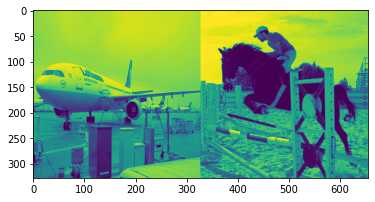

combined_output.shape torch.Size([328, 656, 3])


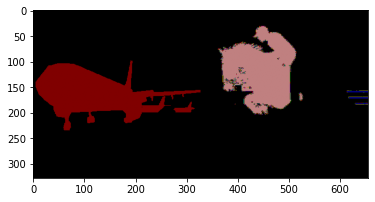

In [ ]:
from torch.utils.data import Dataset, DataLoader
dual_network_ds = DualNetworkDataset(root_strong='VOCdevkit/VOC2012/', 
                                     root_weak='benchmark_RELEASE/', 
                                     is_transform=False,split_strong="val", split_weak="train_noval",img_size=328)
trainloader = DataLoader(dual_network_ds)

for i, d in enumerate(trainloader):
  if (i == 0):
    inputs, targets = d
    print('inputs shape:', inputs.shape)
    print('targets shape:', targets.shape)
    combined_input = inputs[0][0]
    print('combined_input.shape', combined_input.shape)
    print('Showing only one channel of the image:')
    plt.imshow(combined_input)
    plt.show()
    
    combined_output = torch.from_numpy(decode_segmap(targets[0].numpy(), plot=False))
    print('combined_output.shape', combined_output.shape)
    plt.imshow(combined_output)
    plt.show()

    #im_strong, im_weak = torch.split(combined_input, 328, 1)
    #lbl_strong, lbl_weak = torch.split(combined_output, 328, 1)

    #plt.imshow(im_strong)
    #plt.show()
    #plt.imshow(im_weak)
    #plt.show()
    #plt.imshow(lbl_strong)
    #plt.show()
    #plt.imshow(lbl_weak)
    #plt.show()

    break

torch.Size([1, 3, 328, 328])
torch.Size([1, 328, 328])


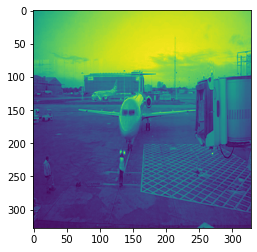

(328, 328)


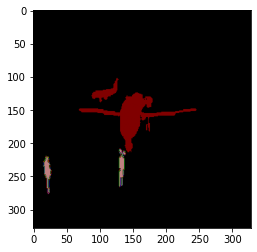

1463


In [ ]:
#!tar -xvf /content/drive/MyDrive/VOCStrong-pre_encoded.tar VOCdevkit/VOC2012/SegmentationClass/pre_encoded/

from torch.utils.data import Dataset, DataLoader
VOC_strong_ds = VOCStrongDataset(root='VOCdevkit/VOC2012/', is_transform=True,split="train",img_size=328)
trainloader = DataLoader(VOC_strong_ds)

for i, d in enumerate(trainloader):
  if i < 1:
        inputs, targets = d
        #inputs, targets = inputs_.to(device), targets_.to(device)
        print(inputs.shape)
        #inputs = inputs.cpu()
        print(targets.shape)
        BS, _, _ = targets.shape
        for j in range(BS):
          plt.imshow(inputs[j][0])
          plt.show()
          nptargets = targets[j].numpy()
          print(nptargets.shape)
          decode_segmap(nptargets, plot=True)
         
print(i)

torch.Size([1, 3, 328, 328])
torch.Size([1, 328, 328])


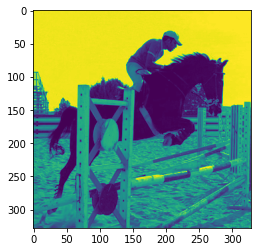

(328, 328)


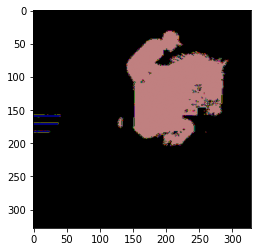

1499


In [ ]:
#For SBD weak to see the data, if we can load the dataset properly

SBD_weak_ds = SBDWeakDataset(root='benchmark_RELEASE/', weak_path='/content/drive/MyDrive/SBDWeak/', is_transform=True, img_size=328, generate_pre_encoded=False)
trainloader2 = DataLoader(SBD_weak_ds)
for i, d in enumerate(trainloader2):
  if i < 1:
        inputs, targets = d
        #inputs, targets = inputs_.to(device), targets_.to(device)
        print(inputs.shape)
        #inputs = inputs.cpu()
        print(targets.shape)
        BS, _, _ = targets.shape
        for j in range(BS):
          plt.imshow(inputs[j][0])
          plt.show()
          nptargets = targets[j].numpy()
          print(nptargets.shape)
          decode_segmap(nptargets, plot=True)
          
print(i)